In [19]:
import torch
import fastcore.all as fc
from collections.abc import Mapping
from operator import attrgetter, itemgetter
from copy import copy

from torch import tensor, nn, optim
from torch.utils.data import DataLoader, default_collate
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from datasets import load_dataset
from miniminiai import * # Lib by @johnowhitaker | pip install miniminiai  
from fastprogress import progress_bar, master_bar
from torcheval.metrics import MulticlassAccuracy, Mean
from functools import partial
from contextlib import contextmanager

In [20]:
x, y = 'image', 'label'
name = 'fashion_mnist'
data = load_dataset(name)

In [21]:
def inplace(f):
    def _f(b):
        f(b)
        return b
    return _f

In [22]:
@inplace
def transformi(b): b[x] = [torch.flatten(TF.to_tensor(o)) for o in b[x]]

In [23]:
bs = 1024
transformed = data.with_transform(transformi)

In [24]:
class DataLoaders:
    def __init__(self, *dls): self.train, self.valid = dls[:2]

    @classmethod
    def from_dd(cls, dd, batch_size, as_tuple=True):
        return cls(*[DataLoader(ds, batch_size, collate_fn=collate_dict(ds)) for ds in dd.values()])

In [25]:
dls = DataLoaders.from_dd(transformed,bs)

In [26]:
# Exceptions
class CancelFitException(Exception): pass
class CancelEpochException(Exception): pass
class CancelBatchException(Exception): pass

In [27]:
def run_cbs(cbs, method_name):
    for cb in sorted(cbs, key=attrgetter('order')):
        method = getattr(cb, method_name, None)
        if method is not None: method()

In [28]:
class Callback:
    order = 0

In [29]:
class DeviceCB(Callback):
    def __init__(self, device=def_device): self.device=device
    def before_fit(self): self.learn.model.to(self.device)
    def before_batch(self): to_device(self.learn.batch, device=self.device)

In [30]:
class MetricsCB(Callback):
    def __init__(self, *ms, **metrics):
        for o in ms: metrics[type(o).__name__] = o # could pass both args and kwargs
        self.metrics = metrics
        self.all_metrics = copy(metrics) # creates shallow copy, any change to previous elements will go, new elements won't effect
        self.all_metrics['loss'] = self.loss = Mean()
    
    def _log(self,d): print(d)
    
    def before_fit(self): self.learn.metrics = self 
    def before_epoch(self): [o.reset() for o in self.all_metrics.values()]
    
    def after_epoch(self): # log to print after each epoch
        log = {k:f'{v.compute():.3f}' for k,v in self.all_metrics.items()} 
        log['epoch'] = self.learn.epoch
        log['train'] = self.learn.model.training
        self._log(log)

    def after_batch(self):
        x,y = to_cpu(self.learn.batch) 
        for m in self.metrics.values(): m.update(to_cpu(self.learn.preds),y)
        self.loss.update(to_cpu(self.learn.loss), weight=len(x))


In [31]:
class TrainCB(Callback):
    def predict(self): self.learn.preds = self.learn.model(self.learn.batch[0])
    def get_loss(self): self.learn.loss = self.learn.loss_func(self.learn.preds, self.learn.batch[1])
    def backward(self): self.learn.loss.backward()
    def step(self): self.learn.opt.step()
    def zero_grad(self): self.learn.opt.zero_grad()

In [32]:
class ProgressCB(Callback):
    order = MetricsCB.order + 1
    def __init__(self, plot=False): self.plot = plot
    
    def before_fit(self):
        self.learn.epochs = self.mbar = master_bar(self.learn.epochs)
        if hasattr(self.learn, 'metrics'): self.learn.metrics._log = self._log
        self.losses = []
    def _log(self, d): self.mbar.write(str(d)) # print log to progress_bar
    def before_epoch(self): self.learn.dl = progress_bar(self.learn.dl, leave=False, parent=self.mbar)
    def after_batch(self):
        self.learn.dl.comment = f'{self.learn.loss:.3f}' # shows loss as batch passes
        if self.plot and hasattr(self.learn, 'metrics') and self.learn.model.training:
            self.losses.append(self.learn.loss.item())
            self.mbar.update_graph([[fc.L.range(self.losses), self.losses]])

In [33]:
class Learner:
    def __init__(self, model, dls, loss_func, lr, cbs, opt_func=optim.SGD): 
        fc.store_attr() # saves from self.model=model, ...
        for cb in cbs: cb.learn = self

    @contextmanager
    def callback_ctxm(self, nm):
        try:
            self.callback(f'before_{nm}')
            yield
            self.callback(f'after_{nm}')
        except globals()[f'Cancel{nm.title()}Exception']: pass

    def one_batch(self):
        self.preds = self.model(self.batch[0])
        self.loss = self.loss_func(self.preds, self.batch[1])
        if self.model.training:
            self.loss.backward()
            self.opt.step()
            self.opt.zero_grad()


    def one_epoch(self, train):
        self.model.train(train)
        self.dl = self.dls.train if train else self.dls.valid
        with self.callback_ctxm('epoch'):
            for self.iter, self.batch in enumerate(self.dl):
                with self.callback_ctxm('batch'):
                    self.predict()
                    self.get_loss()
                    if self.model.training:
                        self.backward()
                        self.step()
                        self.zero_grad()

    def fit(self, n_epochs):
        self.n_epochs = n_epochs
        self.epochs = range(n_epochs)
        self.opt = self.opt_func(self.model.parameters(), self.lr)
        try:
            self.callback('before_fit')
            for self.epoch in self.epochs: 
                self.one_epoch(True)
                self.one_epoch(False)
            self.callback('after_fit')
        except CancelFitException:
            pass

    def __getattr__(self, name):
        if name in ('predict', 'get_loss', 'backward', 'step', 'zero_grad'): return partial(self.callback, name)
        raise AttributeError(name)

    def callback(self, nm): run_cbs(self.cbs, nm)

In [16]:
m, nh = 28*28, 50
def get_model(): return nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))

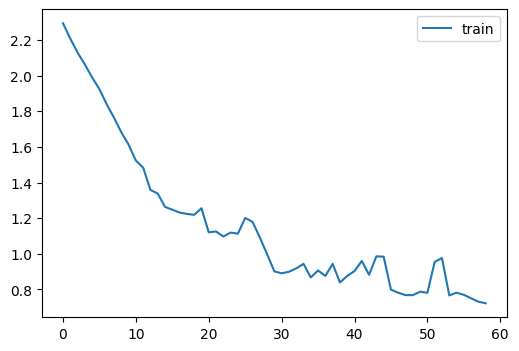

In [34]:
model = get_model()
metrics = MetricsCB(accuracy=MulticlassAccuracy())
learn = Learner(model, dls, F.cross_entropy, lr=0.2, cbs=[TrainCB(), DeviceCB(), metrics, ProgressCB(plot=True)])
learn.fit(1)